In [1]:
import argparse
import json
import logging
import os
import random
import re
from turtle import distance
import torch
import warnings
import pandas as pd
from adjustText import adjust_text
from typing import Tuple, Iterator, List, Dict
from tqdm.notebook import tqdm
import seaborn as sns


import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from sklearn.manifold import TSNE


from os.path import join as pjoin
from collections import defaultdict
from scipy.stats import linregress
from torch.optim import Adam, AdamW

os.environ['PYTHONIOENCODING']='UTF-8'
os.environ['CUDA_LAUNCH_BLOCKING']=str(1)

In [2]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


# Now you can use wildcard import
import plotting as pl
from models import model as md
import utils as ut


# Import specific module with %aimport
%aimport plotting
%aimport models.model
%aimport utils

In [3]:
task = "odd_one_out"
modality = "behavioral"
triplets_dir = "./data/"
lr = learning_rate = 0.001
lmbda = 0.008
temperature = 1
embed_dim = 10
num_threads = 6
device = "cpu"
batch_size = 100
sampling_method = "normal"
rnd_seed = 42
p = None
results_dir = './results/'
plots_dir = './plots/'
epochs = 500
distance_metric = "dot"

In [4]:
def parseargs():
    parser = argparse.ArgumentParser()
    def aa(*args, **kwargs):
        parser.add_argument(*args, **kwargs)
    aa('--task', type=str, default='odd_one_out',
        choices=['odd_one_out', 'similarity_task'])
    aa('--modality', type=str, default='behavioral/',
        #choices=['behavioral/', 'text/', 'visual/', 'neural/'],
        help='define for which modality SPoSE should be perform specified task')
    aa('--triplets_dir', type=str,
        help='directory from where to load triplets')
    aa('--results_dir', type=str, default='./results/',
        help='optional specification of results directory (if not provided will resort to ./results/modality/lambda/rnd_seed/)')
    aa('--plots_dir', type=str, default='./plots/',
        help='optional specification of directory for plots (if not provided will resort to ./plots/modality/lambda/rnd_seed/)')
    aa('--learning_rate', type=float, default=0.001,
        help='learning rate to be used in optimizer')
    aa('--lmbda', type=float,
        help='lambda value determines weight of l1-regularization')
    aa('--temperature', type=float, default=1.,
        help='softmax temperature (beta param) for choice randomness')
    aa('--embed_dim', metavar='D', type=int, default=90,
        help='dimensionality of the embedding matrix')
    aa('--batch_size', metavar='B', type=int, default=100,
        choices=[16, 25, 32, 50, 64, 100, 128, 150, 200, 256],
        help='number of triplets in each mini-batch')
    aa('--epochs', metavar='T', type=int, default=500,
        help='maximum number of epochs to optimize SPoSE model for')
    aa('--window_size', type=int, default=50,
        help='window size to be used for checking convergence criterion with linear regression')
    aa('--steps', type=int, default=10,
        help='save model parameters and create checkpoints every <steps> epochs')
    aa('--sampling_method', type=str, default='normal',
        choices=['normal', 'soft'],
        help='whether random sampling of the entire training set or soft sampling of some fraction of the training set will be performed during each epoch')
    aa('--p', type=float, default=None,
        choices=[None, 0.5, 0.6, 0.7, 0.8, 0.9],
        help='this argument is only necessary for soft sampling. specifies the fraction of *train* to be sampled during an epoch')
    aa('--resume', action='store_true',
        help='whether to resume training at last checkpoint; if not set training will restart')
    aa('--device', type=str, default='cpu',
        choices=['cpu', 'cuda', 'cuda:0', 'cuda:1', 'cuda:2', 'cuda:3', 'cuda:4', 'cuda:5', 'cuda:6', 'cuda:7'])
    aa('--rnd_seed', type=int, default=42,
        help='random seed for reproducibility')
    aa('--distance_metric', type=str, default='dot', choices=['dot', 'euclidean'], help='distance metric')
    aa('--early_stopping', action='store_true', help='train until convergence')
    aa('--num_threads', type=int, default=20, help='number of threads used by PyTorch multiprocessing')
    args = parser.parse_args()
    return args

def setup_logging(file:str, dir:str='./log_files/'):
    if not os.path.exists(dir):
        os.makedirs(dir)
    #create logger at root level (no need to provide specific name, as our logger won't have children)
    logger = logging.getLogger()
    logging.basicConfig(filename=os.path.join(dir, file), filemode='w', level=logging.DEBUG)
    #add console handler to logger
    if len(logger.handlers) < 1:
        #create console handler and set level to debug (lowest severity level)
        handler = logging.StreamHandler()
        #this specifies the lowest-severity log message the logger will handle
        handler.setLevel(logging.DEBUG)
        #create formatter to configure order, structure, and content of log messages
        formatter = logging.Formatter(fmt="%(asctime)s - [%(levelname)s] - %(message)s", datefmt='%d/%m/%Y %I:%M:%S %p')
        #add formatter to handler
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

In [5]:
logger = setup_logging(file='spose_optimization.log', dir=f'./log_files/lmbda_{lmbda}/')
logger.setLevel(logging.INFO)
#load triplets into memory
train_triplets, test_triplets = ut.load_data(device=device, triplets_dir=triplets_dir)
n_items = ut.get_nitems(train_triplets)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [6]:
train_triplets.shape

torch.Size([100000, 3])

In [7]:
batch_size

100

In [8]:
n_items

1854

In [9]:
#load train and test mini-batches
train_batches, val_batches = ut.load_batches(
    train_triplets=train_triplets,
    test_triplets=test_triplets,
    n_items=n_items,
    batch_size=batch_size,
    sampling_method=sampling_method,
    rnd_seed=rnd_seed,
    p=p
)

In [10]:
for i, batch in enumerate(train_batches):
    b = batch.to(device)

In [11]:
temperature = torch.tensor(temperature).to(device)
model = md.SPoSE(in_size=n_items, out_size=embed_dim, init_weights=True)
model.to(device)
optim = Adam(model.parameters(), lr=lr)

In [12]:
print(f'...Creating PATHs')
print()
if results_dir == './results/':
    results_dir = os.path.join(results_dir, modality, f'{embed_dim}d', str(lmbda), f'seed{rnd_seed:02d}')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if plots_dir == './plots/':
    plots_dir = os.path.join(plots_dir, modality, f'{embed_dim}d', str(lmbda), f'seed{rnd_seed}')
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

model_dir = os.path.join(results_dir, 'model')

...Creating PATHs



In [13]:
epochs = 50

In [14]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
start = 0
train_accs, val_accs = [], []
train_losses, val_losses = [], []
loglikelihoods, complexity_losses = [], []
nneg_d_over_time = []

iter = 0
results = {}
logger.info(f'Optimization started for lambda: {lmbda}\n')

print(f'Optimization started for lambda: {lmbda}\n')
for epoch in tqdm(range(start, epochs)):
    model.train()
    batch_llikelihoods = torch.zeros(len(train_batches))
    batch_closses = torch.zeros(len(train_batches))
    batch_losses_train = torch.zeros(len(train_batches))
    batch_accs_train = torch.zeros(len(train_batches))
    for i, batch in enumerate(train_batches):
        optim.zero_grad() #zero out gradients
        batch = batch.to(device)
        logits = model(batch)
        anchor, positive, negative = torch.unbind(torch.reshape(logits, (-1, 3, embed_dim)), dim=1)
        c_entropy = ut.trinomial_loss(anchor, positive, negative, task, temperature, distance_metric)
        l1_pen = md.l1_regularization(model).to(device) #L1-norm to enforce sparsity (many 0s)
        W = model.fc.weight
        pos_pen = torch.sum(F.relu(-W)) #positivity constraint to enforce non-negative values in embedding matrix
        complexity_loss = (lmbda/n_items) * l1_pen
        loss = c_entropy + 0.01 * pos_pen + complexity_loss
        loss.backward()
        optim.step()
        batch_losses_train[i] += loss.item()
        batch_llikelihoods[i] += c_entropy.item()
        batch_closses[i] += complexity_loss.item()
        batch_accs_train[i] += ut.choice_accuracy(anchor, positive, negative, task, distance_metric)
        iter += 1

    avg_llikelihood = torch.mean(batch_llikelihoods).item()
    avg_closs = torch.mean(batch_closses).item()
    avg_train_loss = torch.mean(batch_losses_train).item()
    avg_train_acc = torch.mean(batch_accs_train).item()

    loglikelihoods.append(avg_llikelihood)
    complexity_losses.append(avg_closs)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

Optimization started for lambda: 0.008



  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: xlabel='Count', ylabel='value'>

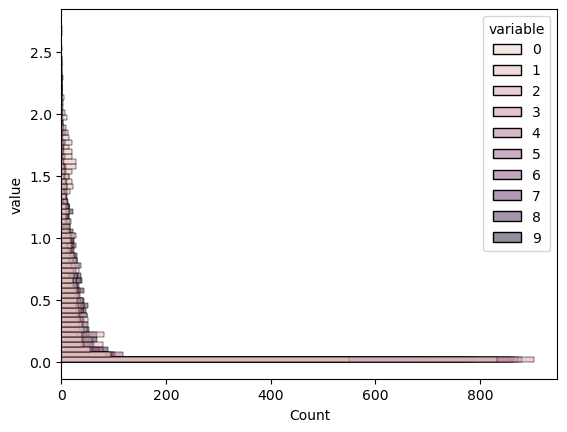

In [15]:
tmp = pd.DataFrame(W.detach().numpy().transpose())
sns.histplot(pd.melt(tmp), y = "value", hue = "variable")


In [16]:
train_accs

[0.4125099778175354,
 0.4546799659729004,
 0.4551299810409546,
 0.45347997546195984,
 0.4551199972629547,
 0.4554300010204315,
 0.455299973487854,
 0.45496997237205505,
 0.4547400176525116,
 0.4566199779510498,
 0.4560699760913849,
 0.45753997564315796,
 0.458079993724823,
 0.46059995889663696,
 0.4638200104236603,
 0.4675299823284149,
 0.47391000390052795,
 0.47863996028900146,
 0.48495998978614807,
 0.4902700185775757,
 0.495449960231781,
 0.49977996945381165,
 0.5034900307655334,
 0.5077599883079529,
 0.5114099979400635,
 0.5150600075721741,
 0.5182399749755859,
 0.5218999981880188,
 0.5254299640655518,
 0.5296100378036499,
 0.5329699516296387,
 0.5376700162887573,
 0.5426200032234192,
 0.5483599901199341,
 0.5540499687194824,
 0.5597600340843201,
 0.5661399960517883,
 0.5722000002861023,
 0.5783599615097046,
 0.5835699439048767,
 0.588890016078949,
 0.5932499766349792,
 0.5971400737762451,
 0.6007300615310669,
 0.6035000085830688,
 0.6064499616622925,
 0.6086600422859192,
 0.611469

In [17]:
array_avg_reps = W.detach().numpy().transpose()
tensor_avg_reps = torch.Tensor(array_avg_reps)
tbl_labels = pd.read_csv("data/unique_id.txt", header=None)
tbl_labels.columns = ["label"]
tbl_avg_reps = pd.DataFrame(array_avg_reps)
tbl_avg_reps["labels"] = tbl_labels

In [18]:
# Initialize t-SNE
tsne_model = TSNE(n_components=2, random_state=42)

# Fit and transform the DataFrame
tsne_result = tsne_model.fit_transform(tbl_avg_reps.drop(columns = "labels"))

# Convert the result to a DataFrame
df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])

C:\Users\MirkoThalmann\miniconda3\envs\representationsID\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Das System kann die angegebene Datei nicht finden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\MirkoThalmann\miniconda3\envs\representationsID\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\MirkoThalmann\miniconda3\envs\representationsID\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MirkoThalmann\miniconda3\envs\representationsID\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_f

In [19]:
df_tsne["label"] = tbl_labels["label"]

## Inspect Semantics of Dimensions
### By Sorting According to Dimensions

In [20]:
tbl_avg_reps.loc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.291606,0.244693,0.259923,0.045816,0.259889,0.117285,0.111228,0.084441,-0.137862
1,-0.291606,1.000000,-0.255712,-0.351852,-0.266884,-0.267352,-0.327050,-0.302554,-0.022695,-0.307656
2,0.244693,-0.255712,1.000000,0.225901,0.091404,0.215369,0.069186,0.138861,0.117244,-0.133945
3,0.259923,-0.351852,0.225901,1.000000,0.038899,0.203466,0.115030,0.202612,0.022435,-0.095964
4,0.045816,-0.266884,0.091404,0.038899,1.000000,0.022975,0.111575,0.120261,0.129408,0.204311
5,0.259889,-0.267352,0.215369,0.203466,0.022975,1.000000,0.164198,0.113010,0.039784,-0.053953
6,0.117285,-0.327050,0.069186,0.115030,0.111575,0.164198,1.000000,0.111729,-0.056099,0.101336
7,0.111228,-0.302554,0.138861,0.202612,0.120261,0.113010,0.111729,1.000000,0.074894,0.031922
8,0.084441,-0.022695,0.117244,0.022435,0.129408,0.039784,-0.056099,0.074894,1.000000,-0.116232
9,-0.137862,-0.307656,-0.133945,-0.095964,0.204311,-0.053953,0.101336,0.031922,-0.116232,1.000000


### By Calculating a lower dimensional embedding

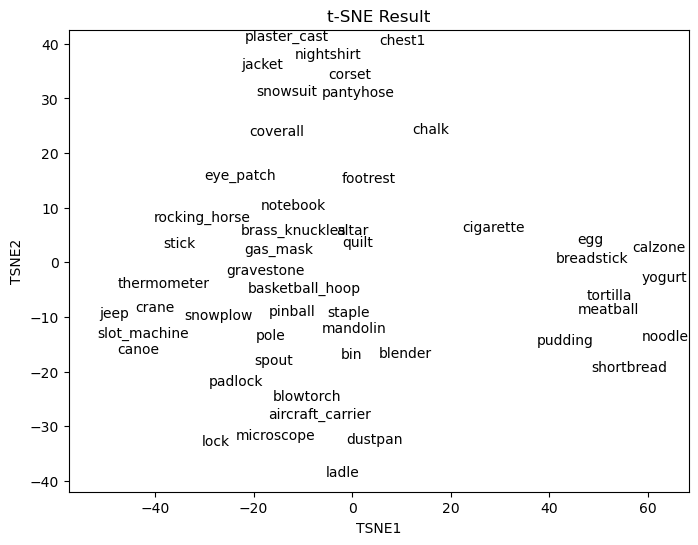

In [21]:
# Print the t-SNE result
df_tsne_sample = df_tsne.sample(50).reset_index()
# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne_sample['TSNE1'], df_tsne_sample['TSNE2'], alpha = 0)

# Add text labels instead of points
texts = []
for i, label in enumerate(df_tsne_sample['label']): 
    texts.append(plt.text(df_tsne_sample['TSNE1'][i], df_tsne_sample['TSNE2'][i], label))
adjust_text(texts)
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('t-SNE Result')
plt.show()

# Finetune average representations using individual-participant data

In [22]:
train_triplets_ID, test_triplets_ID = ut.load_data_ID(device=device, triplets_dir=triplets_dir)
n_items_ID = ut.get_nitems(train_triplets_ID)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [23]:
col_split_id = 3
# Unique values in the specified column
unique_values = np.unique(train_triplets_ID[:, col_split_id])
# Split the array into a list of arrays based on the unique values in the specified column
split_train = [train_triplets_ID[train_triplets_ID[:, col_split_id] == value] for value in unique_values]
split_test = [test_triplets_ID[test_triplets_ID[:, col_split_id] == value] for value in unique_values]

### Separate data set into list elements containing the data from individual participants

In [24]:
l_train_triplets_ID = []
l_test_triplets_ID = []
l_train_batches_ID = []
l_test_batches_ID = []
# divide into list elements and drop subject ID
for i in range(0, len(split_train)):
    l_train_triplets_ID.append(split_train[i][:, 0:3])
    l_test_triplets_ID.append(split_test[i][:, 0:3])

### Generate the batches for every participant by looping over the lists of batches

## ID Model for one participant

In [30]:
#load train and test mini-batches
l_train_batches_ID = []
l_val_batches_ID = []

i = 39

train_batches_ID, val_batches_ID = ut.load_batches_ID(
    train_triplets=l_train_triplets_ID[i],
    test_triplets=l_test_triplets_ID[i],
    average_reps=tensor_avg_reps,
    n_items=n_items_ID,
    batch_size=batch_size,
    sampling_method=sampling_method,
    rnd_seed=rnd_seed,
    p=p
)

train_batches, val_batches = ut.load_batches(
    train_triplets=l_train_triplets_ID[i],
    test_triplets=l_test_triplets_ID[i],
    n_items=n_items_ID,
    batch_size=batch_size,
    sampling_method=sampling_method,
    rnd_seed=rnd_seed,
    p=p
)

In [31]:
model_ID = md.IndependentLinearLayerWithIntercept(array_avg_reps.shape[1])
model_ID.to(device)
optim = Adam(model_ID.parameters(), lr=lr)

### currently, the model set up is for one participant (see just cell above)
has to be set up such that all participants can be run and data for every participant is saved

# todos
- increase epochs to 500
- vary the dimensionality of the learned representations: 5, 10, 20, 49
- 

In [32]:
epochs = 50

In [33]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
start = 0
train_accs_ID, val_accs_ID = [], []
train_losses_ID, val_losses_ID = [], []
loglikelihoods_ID = []
nneg_d_over_time_ID = []

iter = 0
results = {}
logger.info(f'Optimization started for lambda: {lmbda}\n')

print(f'Optimization started for lambda: {lmbda}\n')
for epoch in tqdm(range(start, epochs)):
    model_ID.train()
    batch_llikelihoods = torch.zeros(len(train_batches_ID))
    batch_closses = torch.zeros(len(train_batches_ID))
    batch_losses_train = torch.zeros(len(train_batches_ID))
    batch_accs_train = torch.zeros(len(train_batches_ID))
    for i, batch in enumerate(train_batches_ID):
        optim.zero_grad() #zero out gradients
        batch = batch.to(device)
        logits = model_ID(batch)
        anchor, positive, negative = torch.unbind(torch.reshape(logits, (-1, 3, embed_dim)), dim=1)
        loss = ut.trinomial_loss(anchor, positive, negative, task, temperature, distance_metric)

        ICs = model_ID.intercepts
        Slopes = model_ID.weights

        loss.backward()
        optim.step()
        
        batch_losses_train[i] += loss.item()
        batch_llikelihoods[i] += loss.item()
        batch_accs_train[i] += ut.choice_accuracy(anchor, positive, negative, task, distance_metric)
        iter += 1

    avg_llikelihood_ID = torch.mean(batch_llikelihoods).item()
    avg_train_loss_ID = torch.mean(batch_losses_train).item()
    avg_train_acc_ID = torch.mean(batch_accs_train).item()

    loglikelihoods_ID.append(avg_llikelihood_ID)
    train_losses_ID.append(avg_train_loss_ID)
    train_accs_ID.append(avg_train_acc_ID)

Optimization started for lambda: 0.008



  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
ICs

Parameter containing:
tensor([-0.1030, -0.1353, -0.0716,  0.0047, -0.0321, -0.0050,  0.2219, -0.0932,
         0.0289, -0.0621], requires_grad=True)

In [35]:
type(train_accs_ID)

list

## Evaluate average model

In [36]:
ut.validation(model_ID, val_batches_ID, task, device)

(0.8652576208114624, 0.6076470613479614)

## Evaluate by-participant models

In [37]:
ut.validation(model, val_batches, task, device)

(0.8752763271331787, 0.6041176319122314)

## Loop over all Participants

## Evalute Improvements and Parameters

In [40]:
l_train_ID = list()
l_val_ID = list()
l_val_avg = list()

In [41]:
for tr, te in tqdm(zip(l_train_triplets_ID, l_test_triplets_ID), total = len(l_train_triplets_ID)):
    train_ID = ut.train_ID_model(
        tr, te, array_avg_reps, 
        n_items_ID, batch_size, sampling_method, task, temperature, embed_dim, 
        distance_metric, rnd_seed, p, lr, epochs, device, model_dir
    )
    val_ID = ut.validation(train_ID["model"], train_ID["val_batches_ID"], task, device)
    val_avg = ut.validation(model, train_ID["val_batches_avg"], task, device)

    l_train_ID.append(train_ID)
    l_val_ID.append(val_ID)
    l_val_avg.append(val_avg)

  0%|          | 0/75 [00:00<?, ?it/s]

In [765]:
tr

{'model': IndependentLinearLayerWithIntercept(),
 'train_batches_ID': <utils.BatchGenerator_ID at 0x1e662b61490>,
 'val_batches_ID': <utils.BatchGenerator_ID at 0x1e662b60aa0>,
 'val_batches_avg': <utils.BatchGenerator at 0x1e662b53800>,
 'train_accs': [0.4724999964237213,
  0.5149999856948853,
  0.5450000166893005,
  0.5299999713897705,
  0.5224999785423279,
  0.5,
  0.5249999761581421,
  0.5,
  0.5174999833106995,
  0.5225000381469727,
  0.5224999785423279,
  0.512499988079071,
  0.5174999833106995,
  0.5299999713897705,
  0.5024999976158142,
  0.5149999856948853,
  0.5049999952316284,
  0.5274999737739563,
  0.5024999976158142,
  0.5374999642372131,
  0.5224999785423279,
  0.5174999833106995,
  0.5249999761581421,
  0.5074999928474426,
  0.5224999785423279,
  0.5249999761581421,
  0.4949999749660492,
  0.5349999666213989,
  0.5199999809265137,
  0.512499988079071,
  0.512499988079071,
  0.5324999690055847,
  0.5199999809265137,
  0.5225000381469727,
  0.5174999833106995,
  0.4925000

In [763]:
train_ID

{'model': IndependentLinearLayerWithIntercept(),
 'train_batches_ID': <utils.BatchGenerator_ID at 0x1e662b61490>,
 'val_batches_ID': <utils.BatchGenerator_ID at 0x1e662b60aa0>,
 'val_batches_avg': <utils.BatchGenerator at 0x1e662b53800>,
 'train_accs': [0.4724999964237213,
  0.5149999856948853,
  0.5450000166893005,
  0.5299999713897705,
  0.5224999785423279,
  0.5,
  0.5249999761581421,
  0.5,
  0.5174999833106995,
  0.5225000381469727,
  0.5224999785423279,
  0.512499988079071,
  0.5174999833106995,
  0.5299999713897705,
  0.5024999976158142,
  0.5149999856948853,
  0.5049999952316284,
  0.5274999737739563,
  0.5024999976158142,
  0.5374999642372131,
  0.5224999785423279,
  0.5174999833106995,
  0.5249999761581421,
  0.5074999928474426,
  0.5224999785423279,
  0.5249999761581421,
  0.4949999749660492,
  0.5349999666213989,
  0.5199999809265137,
  0.512499988079071,
  0.512499988079071,
  0.5324999690055847,
  0.5199999809265137,
  0.5225000381469727,
  0.5174999833106995,
  0.4925000

In [42]:
df_eval = pd.DataFrame(
    np.column_stack((np.arange(0, len(l_train_triplets_ID)), l_val_ID, l_val_avg)), 
    columns = ["id", "avg_loss_ID", "avg_acc_ID", "avg_loss_avg", "avg_acc_avg"]
)

In [43]:
df_eval_long = pd.melt(df_eval, id_vars = "id", var_name="variable", value_name="value")
df_swarm = df_eval_long.query("variable in ['avg_acc_avg', 'avg_acc_ID']").copy()
df_swarm.loc[df_swarm['variable'] == 'avg_acc_avg', 'x_position'] = 0.0
df_swarm.loc[df_swarm['variable'] == 'avg_acc_ID', 'x_position'] = 0.5

In [45]:
l_train_acc = []
l_params = []
for id, tr in enumerate(l_train_ID):
    tmp = np.column_stack((np.repeat(id, len(tr["train_accs"])), np.arange(0, len(tr["train_accs"])), tr["train_accs"]))
    l_train_acc.append(tmp)
    tmp = np.column_stack((np.repeat(id, embed_dim), np.arange(0, embed_dim), tr["ics"].detach().numpy(), tr["Slopes"].detach().numpy()))
    l_params.append(tmp)
m_train_acc = np.concatenate(l_train_acc, axis = 0)
df_train_acc = pd.DataFrame(m_train_acc, columns = ["id", "epoch", "train_acc"])
m_params = np.concatenate(l_params, axis = 0)
df_params = pd.DataFrame(m_params, columns = ["id", "dim", "intercept", "slope"])

In [46]:
df_train_acc["epoch_bin"] = pd.cut(df_train_acc["epoch"], bins = 20, labels=False, )
df_train_acc_agg = df_train_acc.groupby(["id", 'epoch_bin'], observed=False).agg({"train_acc": ['mean']}).reset_index()
df_train_acc_agg.columns = ['_'.join(col).strip() for col in df_train_acc_agg.columns.values]
df_train_acc_agg.columns = ["id", "epoch_bin", "train_acc_mean"]
df_train_acc_agg = df_train_acc_agg.groupby("epoch_bin", observed=False)["train_acc_mean"].agg(["mean", "std"]).reset_index()
df_train_acc_agg["ci_95"] = df_train_acc_agg["std"]/np.sqrt(len(l_train_triplets_ID))

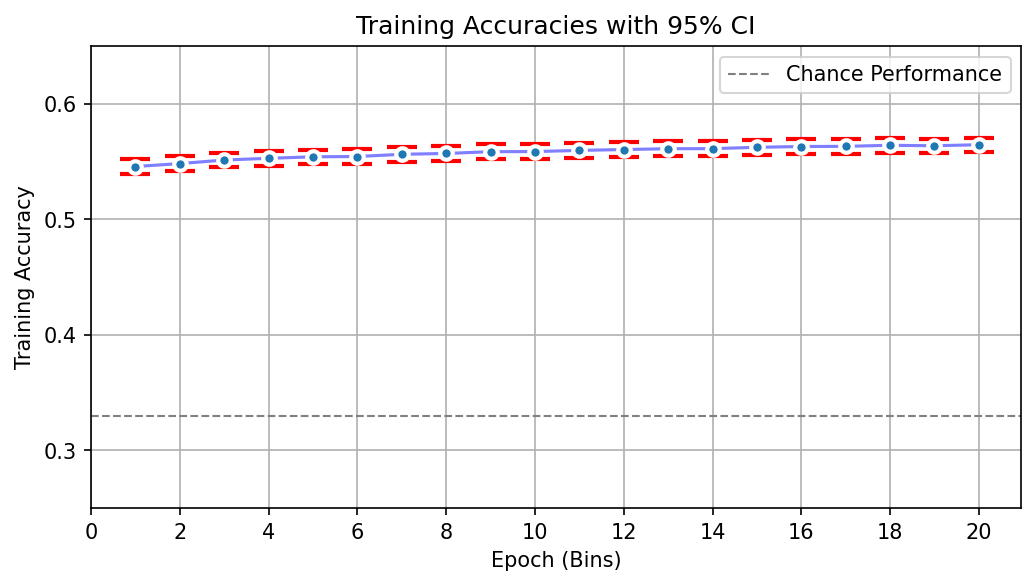

In [47]:
# Plot the line without crossing the points 
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = plt.subplot(111)
ax.plot(
    df_train_acc_agg["epoch_bin"] + 1, df_train_acc_agg["mean"], 
    linestyle='-', color='blue', alpha=0.5
) 
ax.errorbar(
    df_train_acc_agg["epoch_bin"] + 1, df_train_acc_agg["mean"], yerr=df_train_acc_agg["ci_95"],
    fmt="o", ecolor="red", capsize=7, capthick=1.5, markersize=6, markeredgewidth=2, markeredgecolor='white', 
)
ax.set_xticks(ticks=range(0, 21, 2))
ax.set_yticks(ticks=np.arange(0, 1.1, .1))
ax.axhline(y=0.33, color='grey', linestyle='--', linewidth=1, label='Chance Performance')
ax.set_ylim(.25, .65)
# Add labels and title
ax.set_xlabel('Epoch (Bins)') 
ax.set_ylabel('Training Accuracy') 
ax.set_title('Training Accuracies with 95% CI') 
ax.legend()
# Add gridlines
ax.grid(True)
plt.show()

In [48]:
means = df_swarm.groupby('variable')['value'].mean()
stds = df_swarm.groupby('variable')['value'].std()
stds = stds /np.sqrt(len(l_train_triplets_ID))

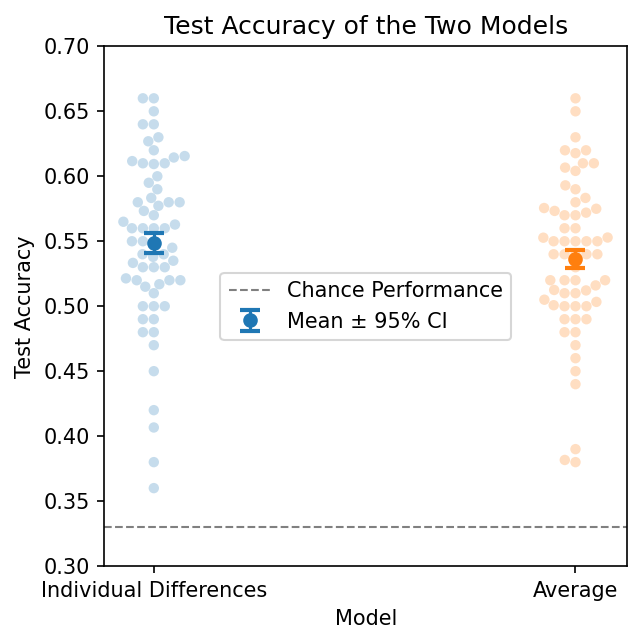

In [52]:
# Plot the line without crossing the points 
fig = plt.figure(figsize=(4.5, 4.5), dpi=150)
ax = plt.subplot(111)
ax = sns.swarmplot(x='variable', y='value', data=df_swarm, alpha=.25, hue="variable", dodge=False)
# Get the current colors from the swarm plot 
palette = {entry: color for entry, color in zip(df_swarm['variable'].unique(), sns.color_palette())} 
# Add mean and standard deviation as error bars
for category in df_swarm['variable'].unique():
    mean = means[category]
    std = stds[category]
    ax.errorbar(
        category, mean, yerr=std, fmt='o', color=palette[category], capsize=5, 
        capthick=2, label=f'Mean ± 95% CI' if category == df_swarm['variable'].unique()[0] else ""
    )
ax.axhline(y=0.33, color='grey', linestyle='--', linewidth=1, label='Chance Performance')
ax.set_ylim(.3, .7)
# Set the new x-ticks and labels
ax.set_xticks(ticks=[0, 1], labels=['Individual Differences', 'Average'])
ax.set_xlabel('Model')
ax.set_ylabel('Test Accuracy') 
ax.set_title('Test Accuracy of the Two Models')
ax.legend(loc=10)
plt.show()

In [55]:
from scipy.stats import pearsonr

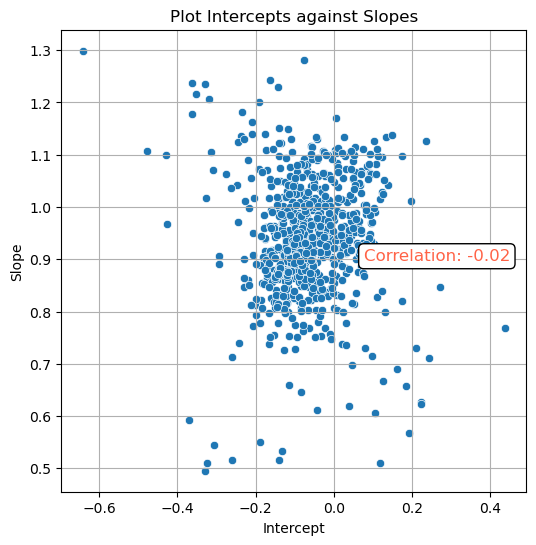

In [56]:
# Plot the line without crossing the points 
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.subplot(111)
# Calculate correlation
corr, _ = pearsonr(df_params['intercept'], df_params['slope']) 
ax = sns.scatterplot(df_params, x = "intercept", y = "slope")
ax.annotate(
    f'Correlation: {corr:.2f}', xy=(0.65, 0.5), xycoords='axes fraction', 
    fontsize=12, color='tomato',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white') 
) 
# Add labels and title 
ax.set_xlabel('Intercept') 
ax.set_ylabel('Slope') 
ax.set_title('Plot Intercepts against Slopes')
ax.grid(True)
# Display the plot 
plt.show()

In [725]:
import pickle

In [726]:
# Load from a file 
with open("results/ID/2d/0.008/seed01/results-ID.pkl", 'rb') as f: 
    loaded_data = pickle.load(f)